In [83]:
import pandas as pd

# Helpers
from utils.data import alfred_dataset
from utils.models import nowcaster, forecast

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.tools.eval_measures import rmse
from epftoolbox.evaluation import GW

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%reload_ext autoreload
%autoreload 2

# ***1 - Data***

### 1.1 - Alfred

In [84]:
indices = ["CPI", "CCPI", "FCPI", "GCPI"]
df = alfred_dataset(indices)
df.head()

,date,CPI,CCPI,FCPI,GCPI
0,1967-01-01,32.9,34.2,33.9,26.3
1,1967-02-01,33.0,34.2,33.8,26.2
2,1967-03-01,33.0,34.3,33.8,26.1
3,1967-04-01,33.1,34.4,33.7,26.4
4,1967-05-01,33.1,34.5,33.7,26.4


### 1.2 - News

In [85]:
df_news = pd.read_json('data/nowcaster/news_index.jsonl', lines=True)
df_news.head()

,date,NEWS
0,2010-01-01,100.000757
1,2010-02-01,100.599369
2,2010-03-01,100.663992
3,2010-04-01,101.086770
4,2010-05-01,101.073790


### 1.3 - Merge

In [86]:
df = df.merge(df_news, on='date')
df

,date,CPI,CCPI,FCPI,GCPI,NEWS
0,2010-01-01,217.488,220.633,218.489,242.036,100.000757
1,2010-02-01,217.281,220.731,218.552,235.748,100.599369
2,2010-03-01,217.353,220.783,218.990,233.103,100.663992
3,2010-04-01,217.403,220.822,219.209,232.594,101.086770
4,2010-05-01,217.290,220.962,219.331,227.765,101.073790
...,...,...,...,...,...,...
163,2023-08-01,306.187,309.656,323.754,326.825,113.206184
164,2023-09-01,307.288,310.644,324.356,332.019,113.338719
165,2023-10-01,307.531,311.390,325.312,317.678,113.484654
166,2023-11-01,308.024,312.349,325.870,304.982,113.586926


In [87]:
indices = [col for col in df.columns if col != 'date']
print(f'Regressors: {indices}')

Regressors: ['CPI', 'CCPI', 'FCPI', 'GCPI', 'NEWS']


In [88]:
df['NEWS'] = df['NEWS'] + (df['CPI'].iloc[0] - df['NEWS'].iloc[0]) 
df

,date,CPI,CCPI,FCPI,GCPI,NEWS
0,2010-01-01,217.488,220.633,218.489,242.036,217.488000
1,2010-02-01,217.281,220.731,218.552,235.748,218.086613
2,2010-03-01,217.353,220.783,218.990,233.103,218.151236
3,2010-04-01,217.403,220.822,219.209,232.594,218.574014
4,2010-05-01,217.290,220.962,219.331,227.765,218.561033
...,...,...,...,...,...,...
163,2023-08-01,306.187,309.656,323.754,326.825,230.693428
164,2023-09-01,307.288,310.644,324.356,332.019,230.825963
165,2023-10-01,307.531,311.390,325.312,317.678,230.971898
166,2023-11-01,308.024,312.349,325.870,304.982,231.074170


### 1.4 - $\pi$-Computes

In [89]:
# Percentage-Change period (T=1 is m-o-m, T=1 is y-o-y)
T = 1

# Computing percentage changes
df[[f'pi-{i}' for i in indices]] = 100*df[indices].pct_change(periods=T)
#df['pi-NEWS'] = df['pi-NEWS'] + 0.02   # Centering news inflation around 2% as FED target
df = df.dropna()
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,167,2016-12-30 21:24:47.425149696,2010-02-01 00:00:00,2013-07-16 12:00:00,2017-01-01 00:00:00,2020-06-16 00:00:00,2023-12-01 00:00:00,NaN
CPI,167.0,250.070054,217.199,233.1965,243.618,259.076,308.742,24.326261
CCPI,167.0,254.361138,220.731,234.108,250.467,267.3875,313.209,25.125582
FCPI,167.0,256.75485,218.552,237.3175,248.735,268.7345,326.545,28.04721
GCPI,167.0,260.463503,160.74,220.8675,250.369,304.9415,411.984,51.548526
NEWS,167.0,221.170477,215.692231,218.552593,220.283714,221.137724,231.07417,4.148327
pi-CPI,167.0,0.210382,-0.78404,0.060039,0.206228,0.327039,1.248288,0.270982
pi-CCPI,167.0,0.210153,-0.476283,0.123729,0.185767,0.239914,0.811903,0.162498
pi-FCPI,167.0,0.24129,-0.385036,0.087295,0.174585,0.302901,1.380187,0.277991
pi-GCPI,167.0,0.250679,-19.134667,-2.242814,0.509224,2.816054,14.874853,4.778488


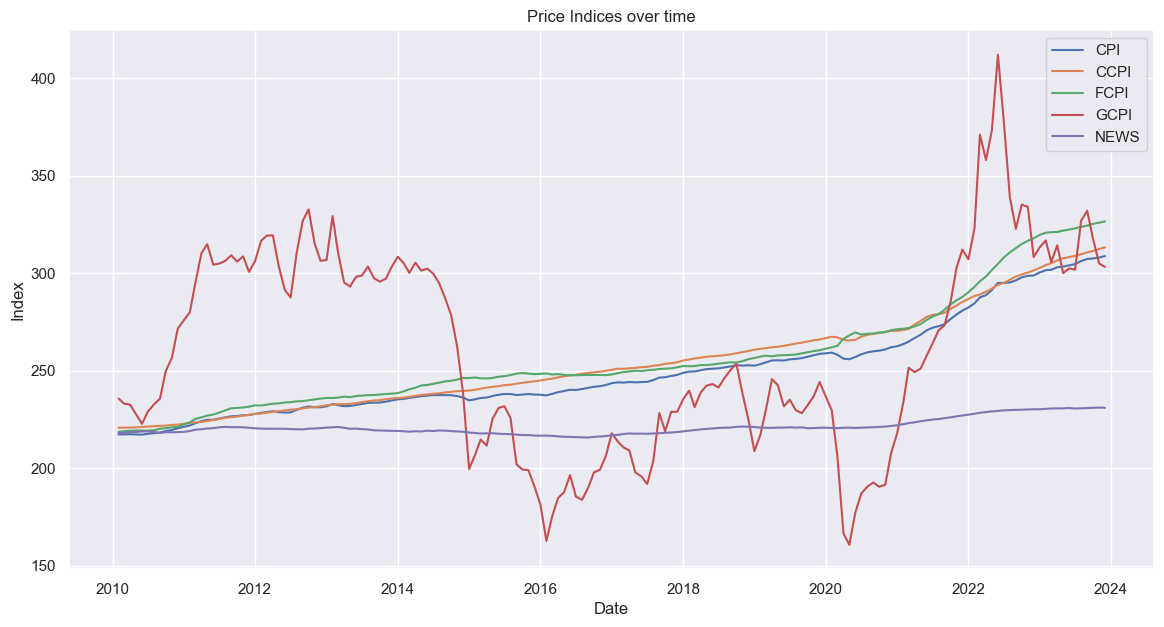

In [90]:
plt.figure(figsize=(14, 7))

# Plot each column on the same plot
for col in df.columns:
    if col != 'date' and not col.startswith('pi-'):
        plt.plot(df['date'], df[col], label=col)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Price Indices over time')
plt.legend(loc='best')  # Add a legend to differentiate columns

# Show the plot
plt.show()

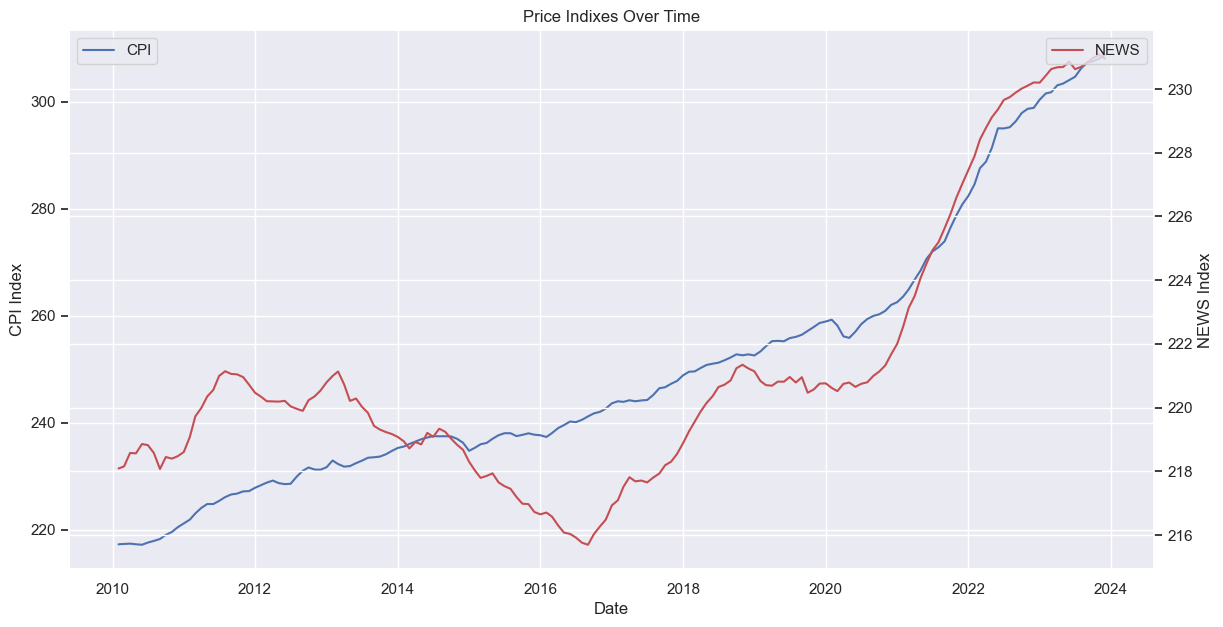

In [91]:
# Set the plot size
plt.figure(figsize=(14, 7))


# Create the first axis
ax1 = plt.gca()
# Create a secondary y-axis for 'NEWS'
ax2 = ax1.twinx()

# Plot each column except 'NEWS' on the primary y-axis
for col in df.columns:
    #if col != 'date' and col != 'NEWS' and not col.startswith('pi-'):
    if col=='CPI':
        sns.lineplot(x='date', y=col, data=df, ax=ax1, label=col)
    elif col == 'NEWS':
        sns.lineplot(x='date', y='NEWS', data=df, ax=ax2, label='NEWS', color='r')

# Set secondary y-axis label and add its legend
ax2.set_ylabel('NEWS Index')
ax2.legend(loc='upper right')  # Adjust legend location if needed

# Add labels, title, and legend
ax1.set_xlabel('Date')
ax1.set_ylabel('CPI Index')
ax1.set_title('Price Indixes Over Time')
ax1.legend(loc='upper left')  # Adjust legend location if needed

# Show the plot
plt.show()


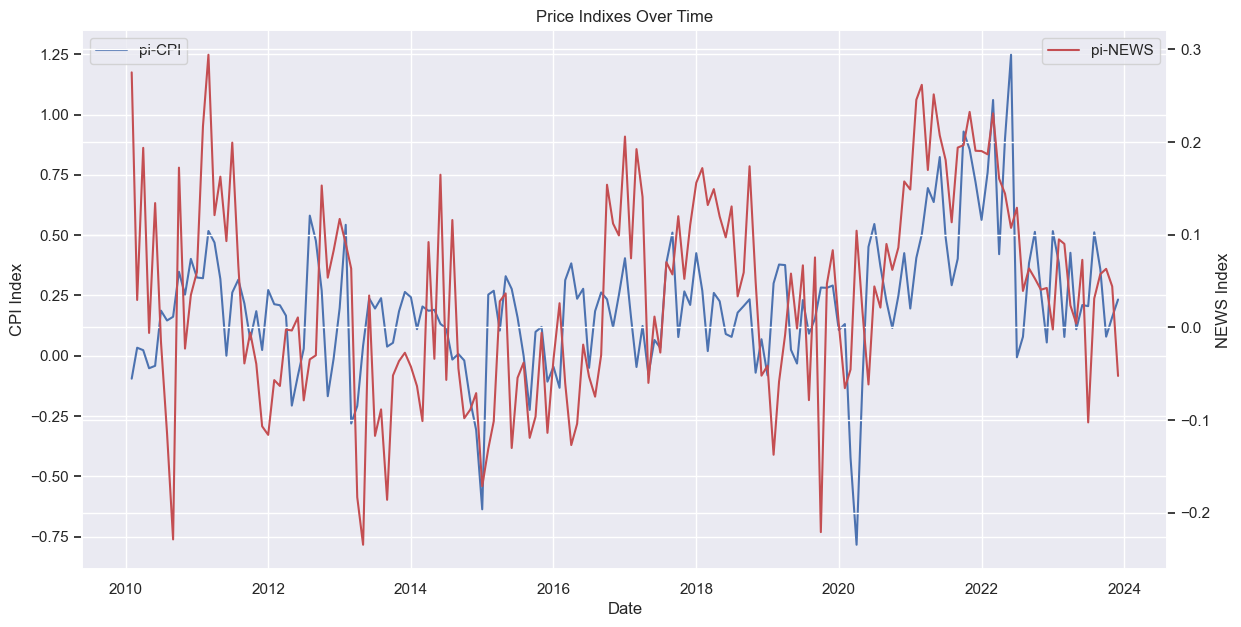

In [92]:
# Set the plot size
plt.figure(figsize=(14, 7))


# Create the first axis
ax1 = plt.gca()
# Create a secondary y-axis for 'NEWS'
ax2 = ax1.twinx()

# Plot each column except 'NEWS' on the primary y-axis
for col in df.columns:
    #if col != 'date' and col != 'NEWS' and not col.startswith('pi-'):
    if col=='pi-CPI':
        sns.lineplot(x='date', y=col, data=df, ax=ax1, label=col)
    elif col == 'pi-NEWS':
        sns.lineplot(x='date', y=col, data=df, ax=ax2, label=col, color='r')

# Set secondary y-axis label and add its legend
ax2.set_ylabel('NEWS Index')
ax2.legend(loc='upper right')  # Adjust legend location if needed

# Add labels, title, and legend
ax1.set_xlabel('Date')
ax1.set_ylabel('CPI Index')
ax1.set_title('Price Indixes Over Time')
ax1.legend(loc='upper left')  # Adjust legend location if needed

# Show the plot
plt.show()

### 1.5 - De-seasonalize Gasoline

In [93]:
# Load gasoline data
gasoline_df = pd.read_excel("data/nowcaster/2f. EMM_EPMR_PTE_NUS_DPGw.xls", sheet_name=1, header=2)
gasoline_df['Date'] = pd.to_datetime(gasoline_df['Date'])
gasoline_df = gasoline_df.rename(columns={'Date': 'date', 'Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)': 'GasolineNSA'})

# From weekly to monthly data
gasoline_df = gasoline_df.set_index('date').resample('M').mean().reset_index()
gasoline_df['date'] = gasoline_df['date'].dt.to_period('M').dt.to_timestamp()

gasoline_df['pi-GasolineNSA'] = 100*gasoline_df['GasolineNSA'].pct_change(periods=T)
gasoline_df = gasoline_df.merge(df[['date', 'pi-GCPI']], on='date')

gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI
0,2010-02-01,2.64400,-2.615101,-2.597961
1,2010-03-01,2.77160,4.826021,-1.121961
2,2010-04-01,2.84825,2.765551,-0.218358
3,2010-05-01,2.83620,-0.423067,-2.076150
4,2010-06-01,2.73150,-3.691559,-2.204026
...,...,...,...,...
162,2023-08-01,3.83975,6.748679,8.297657
163,2023-09-01,3.83600,-0.097663,1.589230
164,2023-10-01,3.61280,-5.818561,-4.319331
165,2023-11-01,3.31800,-8.159876,-3.996500


In [94]:
gasoline_df['diff'] = gasoline_df['pi-GasolineNSA'] - gasoline_df['pi-GCPI']
gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI,diff
0,2010-02-01,2.64400,-2.615101,-2.597961,-0.017141
1,2010-03-01,2.77160,4.826021,-1.121961,5.947982
2,2010-04-01,2.84825,2.765551,-0.218358,2.983909
3,2010-05-01,2.83620,-0.423067,-2.076150,1.653083
4,2010-06-01,2.73150,-3.691559,-2.204026,-1.487533
...,...,...,...,...,...
162,2023-08-01,3.83975,6.748679,8.297657,-1.548977
163,2023-09-01,3.83600,-0.097663,1.589230,-1.686892
164,2023-10-01,3.61280,-5.818561,-4.319331,-1.499230
165,2023-11-01,3.31800,-8.159876,-3.996500,-4.163376


In [95]:
import numpy as np

# Compute seasonal factor
gasoline_df['sf'] = [np.mean([gasoline_df['diff'].iloc[i - (j*12)] for j in range(1, 4)]) if i>48 else gasoline_df['diff'].iloc[i] for i in gasoline_df.index]

# De-seasonalize the gasoline pct-change
gasoline_df['pi-Gasoline'] = gasoline_df['pi-GasolineNSA'] - gasoline_df['sf']

gasoline_df

,date,GasolineNSA,pi-GasolineNSA,pi-GCPI,diff,sf,pi-Gasoline
0,2010-02-01,2.64400,-2.615101,-2.597961,-0.017141,-0.017141,-2.597961
1,2010-03-01,2.77160,4.826021,-1.121961,5.947982,5.947982,-1.121961
2,2010-04-01,2.84825,2.765551,-0.218358,2.983909,2.983909,-0.218358
3,2010-05-01,2.83620,-0.423067,-2.076150,1.653083,1.653083,-2.076150
4,2010-06-01,2.73150,-3.691559,-2.204026,-1.487533,-1.487533,-2.204026
...,...,...,...,...,...,...,...
162,2023-08-01,3.83975,6.748679,8.297657,-1.548977,-2.103769,8.852449
163,2023-09-01,3.83600,-0.097663,1.589230,-1.686892,-1.222521,1.124859
164,2023-10-01,3.61280,-5.818561,-4.319331,-1.499230,-0.456058,-5.362503
165,2023-11-01,3.31800,-8.159876,-3.996500,-4.163376,-2.990474,-5.169402


In [96]:
df = df.merge(gasoline_df[['date', 'pi-Gasoline']], on='date')
df = df.dropna()
df

,date,CPI,CCPI,FCPI,GCPI,NEWS,pi-CPI,pi-CCPI,pi-FCPI,pi-GCPI,pi-NEWS,pi-Gasoline
0,2010-02-01,217.281,220.731,218.552,235.748,218.086613,-0.095178,0.044418,0.028834,-2.597961,0.275239,-2.597961
1,2010-03-01,217.353,220.783,218.990,233.103,218.151236,0.033137,0.023558,0.200410,-1.121961,0.029632,-1.121961
2,2010-04-01,217.403,220.822,219.209,232.594,218.574014,0.023004,0.017664,0.100005,-0.218358,0.193801,-0.218358
3,2010-05-01,217.290,220.962,219.331,227.765,218.561033,-0.051977,0.063399,0.055655,-2.076150,-0.005939,-2.076150
4,2010-06-01,217.199,221.194,219.285,222.745,218.854362,-0.041880,0.104995,-0.020973,-2.204026,0.134209,-2.204026
...,...,...,...,...,...,...,...,...,...,...,...,...
162,2023-08-01,306.187,309.656,323.754,326.825,230.693428,0.511772,0.230138,0.243057,8.297657,0.031221,8.852449
163,2023-09-01,307.288,310.644,324.356,332.019,230.825963,0.359584,0.319064,0.185944,1.589230,0.057451,1.124859
164,2023-10-01,307.531,311.390,325.312,317.678,230.971898,0.079079,0.240146,0.294738,-4.319331,0.063223,-5.362503
165,2023-11-01,308.024,312.349,325.870,304.982,231.074170,0.160309,0.307974,0.171528,-3.996500,0.044279,-5.169402


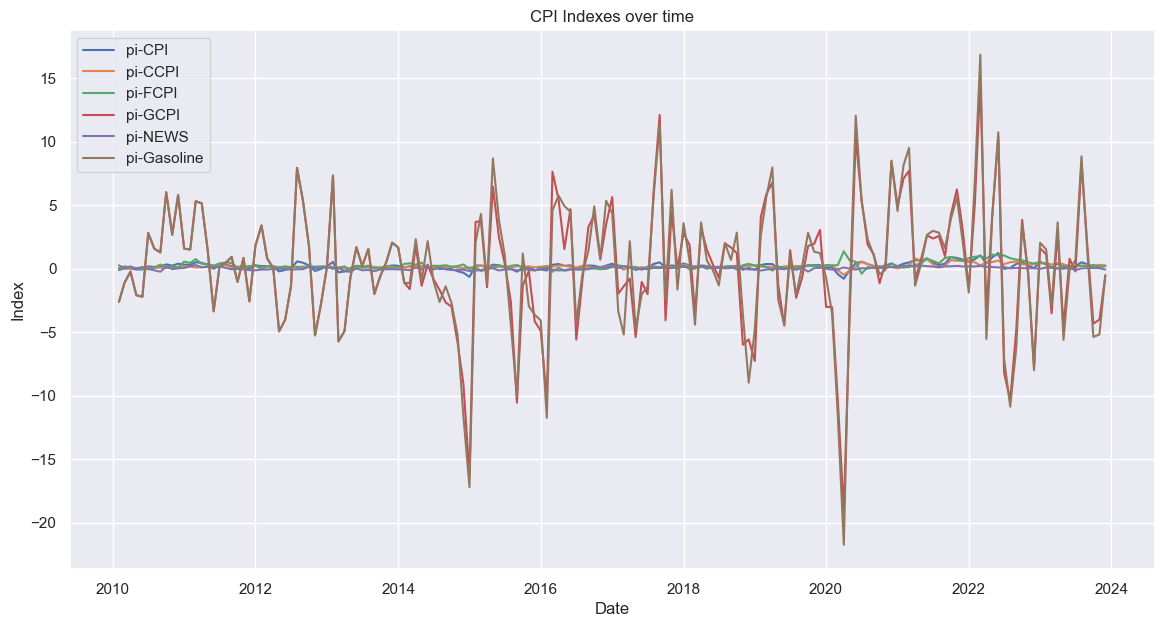

In [97]:
plt.figure(figsize=(14, 7))

# Plot each column on the same plot
for col in df.columns:
    if col != 'date' and col.startswith('pi'):
        plt.plot(df['date'], df[col], label=col)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('CPI Indexes over time')
plt.legend(loc='best')  # Add a legend to differentiate columns

# Show the plot
plt.show()

# ***2 - Models***

In [98]:
models = {}

In [99]:
# Train/Test datesplit
train_start = pd.to_datetime("2015-01-01")
train_end = pd.to_datetime("2020-01-01")
train_range = pd.date_range(train_start, train_end, freq="MS", inclusive="left")

test_start = pd.to_datetime("2020-01-01")
test_end = pd.to_datetime("2024-01-01")
test_range = pd.date_range(test_start, test_end, freq="MS", inclusive="left")

In [100]:
ycol = "pi-CPI"

### 2.0 - Baseline: *FED*

In [101]:
xcols_fed = ["pi-CCPI", "pi-FCPI", "pi-Gasoline"]

# Build nowcaster
model_fed = nowcaster(df, xcols_fed, ycol, train_range)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     153.6
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           5.41e-27
Time:                        12:04:59   Log-Likelihood:                 82.086
No. Observations:                  60   AIC:                            -156.2
Df Residuals:                      56   BIC:                            -147.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0215      0.026      0.842      

In [102]:
models.update({'fed': {'xcols': xcols_fed, 'model': model_fed}})

### 2.1 - *News Index*

In [103]:
xcols_news = ["pi-NEWS"]

# Build nowcaster
model_news = nowcaster(df, xcols_news, ycol, train_range)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3.131
Date:                Wed, 05 Jun 2024   Prob (F-statistic):             0.0821
Time:                        12:05:00   Log-Likelihood:                 16.993
No. Observations:                  60   AIC:                            -29.99
Df Residuals:                      58   BIC:                            -25.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1445      0.024      5.964      0.0

In [104]:
models.update({'news': {'xcols': xcols_news, 'model': model_news}})

### 2.2 - *Fed + News*

In [105]:
xcols_fednews = ["pi-CCPI", "pi-FCPI", "pi-Gasoline", "pi-NEWS"]

# Build nowcaster
model_fednews = nowcaster(df, xcols_fednews, ycol, train_range)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     120.9
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           1.45e-26
Time:                        12:05:00   Log-Likelihood:                 83.859
No. Observations:                  60   AIC:                            -157.7
Df Residuals:                      55   BIC:                            -147.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0171      0.025      0.682      

In [106]:
models.update({'fed+news': {'xcols': xcols_fednews, 'model': model_fednews}})

### 2.3 *FED-GAS+NEWS*

In [107]:
xcols_fedgasnews = ["pi-CCPI", "pi-FCPI", "pi-NEWS"]

# Build nowcaster
model_fedgasnews = nowcaster(df, xcols_fedgasnews, ycol, train_range)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     2.702
Date:                Wed, 05 Jun 2024   Prob (F-statistic):             0.0541
Time:                        12:05:00   Log-Likelihood:                 19.472
No. Observations:                  60   AIC:                            -30.94
Df Residuals:                      56   BIC:                            -22.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.073      0.159      0.8

In [108]:
models.update({'fed-gas+news': {'xcols': xcols_fedgasnews, 'model': model_fedgasnews}})

### 2.4 - *CCPI+NEWS*

In [109]:
xcols_ccpinews = ["pi-CCPI", "pi-NEWS"]

# Build nowcaster
model_ccpinews = nowcaster(df, xcols_ccpinews, ycol, train_range)

                            OLS Regression Results                            
Dep. Variable:                 pi-CPI   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     3.921
Date:                Wed, 05 Jun 2024   Prob (F-statistic):             0.0254
Time:                        12:05:00   Log-Likelihood:                 19.283
No. Observations:                  60   AIC:                            -32.57
Df Residuals:                      57   BIC:                            -26.28
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.071      0.036      0.9

In [110]:
models.update({'ccpi+news': {'xcols': xcols_ccpinews, 'model': model_ccpinews}})

### Results Tables

In [111]:
from stargazer.stargazer import Stargazer

In [112]:
# Generate the LaTeX table
stargazer = Stargazer([d['model'] for _, d in models.items()])
stargazer.title("Regression Results")
stargazer.custom_columns([n for n, _ in models.items()], [1]*len(models))
stargazer.dependent_variable_name('Core CPI')
stargazer.show_degrees_of_freedom(False)

# Print the LaTeX code
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Regression Results}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{5}{c}{\textit{Dependent variable: Core CPI}} \
\cr \cline{2-6}
\\[-1.8ex] & \multicolumn{1}{c}{fed} & \multicolumn{1}{c}{news} & \multicolumn{1}{c}{fed+news} & \multicolumn{1}{c}{fed-gas+news} & \multicolumn{1}{c}{ccpi+news}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) \\
\hline \\[-1.8ex]
 const & 0.021$^{}$ & 0.144$^{***}$ & 0.017$^{}$ & 0.012$^{}$ & 0.003$^{}$ \\
& (0.026) & (0.024) & (0.025) & (0.073) & (0.071) \\
 pi-CCPI & 0.616$^{***}$ & & 0.634$^{***}$ & 0.814$^{**}$ & 0.810$^{**}$ \\
& (0.135) & & (0.133) & (0.383) & (0.381) \\
 pi-FCPI & 0.186$^{***}$ & & 0.176$^{***}$ & -0.105$^{}$ & \\
& (0.064) & & (0.063) & (0.177) & \\
 pi-Gasoline & 0.035$^{***}$ & & 0.034$^{***}$ & & \\
& (0.002) & & (0.002) & & \\
 pi-NEWS & & 0.419$^{*}$ & 0.149$^{*}$ & 0.456$^{*}$ & 0.448$^{*}$ \\
& & (0.237) & (0.081) & (0.232) & (0.230) \\
\hl

# 3 - ***Evaluations***

### 3.1 - *Forcasting*

In [113]:
from functools import reduce

yh = []

#for t in pd.date_range(test_start, test_end, freq="MS", inclusive="left"):
for name, d in models.items():
    model_forecast = forecast(df, d['model'], d['xcols'], ycol, test_range[0], len(test_range))
    model_forecast = model_forecast.rename(columns={'forecast': name})
    yh.append(model_forecast)

yh.append(df[['date', ycol]].rename(columns={ycol: 'realized'}))

forecasts_df = reduce(lambda x, y: x.merge(y, on='date'), yh)

# If monthly, annualize
if T==1:
    forecasts_cols = forecasts_df.drop(columns='date').columns
    forecasts_df[forecasts_cols] = 100*((forecasts_df[forecasts_cols]/100 + 1)**12 - 1)
    forecasts_df

forecasts_df.head()

,date,fed,news,fed+news,fed-gas+news,ccpi+news,realized
0,2020-01-01,2.338014,1.656292,2.267969,1.712687,1.785461,1.288137
1,2020-02-01,2.482564,1.675473,2.416182,1.716212,1.793286,1.587293
2,2020-03-01,2.326392,1.706053,2.276549,1.835742,1.910868,-4.956859
3,2020-04-01,1.571906,1.711612,1.528181,1.605000,1.693767,-9.013187
4,2020-05-01,0.416449,1.759476,0.379824,0.967265,1.218748,-1.294737


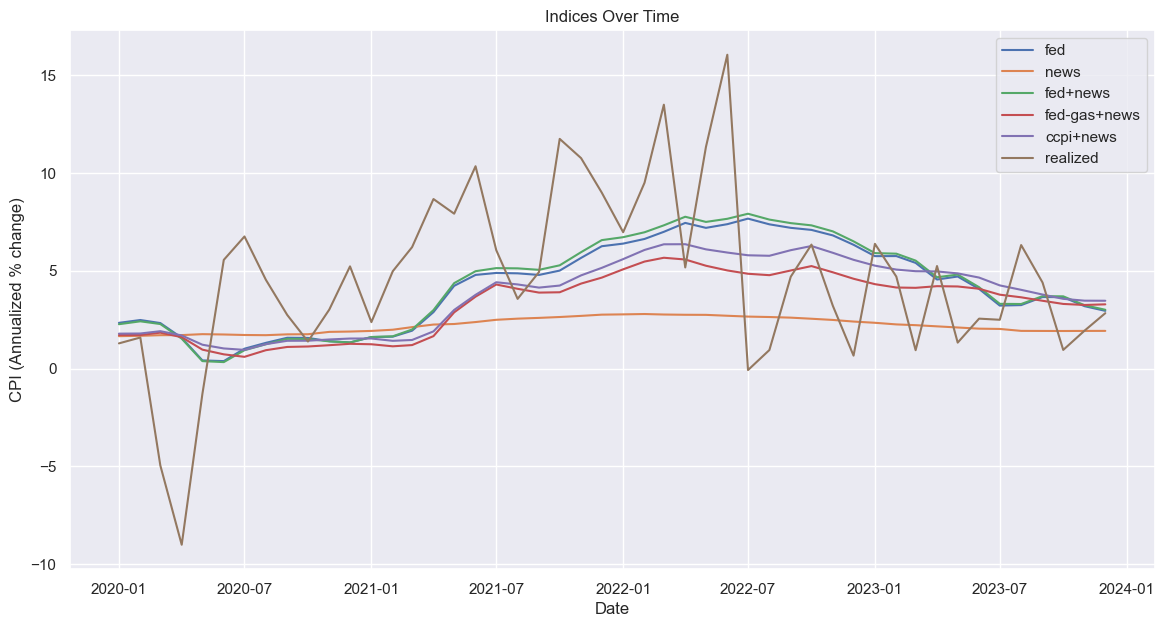

In [114]:
plt.figure(figsize=(14, 7))

# Plot each column on the same plot
for col in forecasts_df.columns:
    if col != 'date':
        plt.plot(forecasts_df['date'], forecasts_df[col], label=col)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('CPI (Annualized % change)')
plt.title('Indices Over Time')
plt.legend(loc='best')  # Add a legend to differentiate columns

# Show the plot
plt.show()

### 3.2 - *Scores*

In [115]:
baseline = 'fed'

In [116]:
def GW_adapter(forecasts):
    return np.repeat(forecasts.to_numpy()[:, np.newaxis], 24, axis=1)

res = []

for name, model in models.items():
    # Computing Scores
    rmse_v = rmse(forecasts_df[name], forecasts_df['realized'])
    gw = GW(GW_adapter(forecasts_df['realized']), GW_adapter(forecasts_df[baseline]), GW_adapter(forecasts_df[name]), version='multivariate')

    # Adding to the df
    res.append({'model': name, 'rmse': rmse_v, 'gw': gw})
    # print(f"{'-'*10} {name.upper()} {'-'*10}")
    # print(f"RMSE: {rmse}")
    # print(f"Giacomini-White: {gw}")

# Creating the df
res_df = pd.DataFrame(res)
res_df

,model,rmse,gw
0,fed,4.097708,1.000000
1,news,4.850780,1.000000
2,fed+news,4.071387,0.197916
3,fed-gas+news,4.302772,1.000000
4,ccpi+news,4.211183,1.000000


In [117]:
pi_cols = [col for col in df.columns if col.startswith('pi-')]
pi_df = df[pi_cols]
pi_df

,pi-CPI,pi-CCPI,pi-FCPI,pi-GCPI,pi-NEWS,pi-Gasoline
0,-0.095178,0.044418,0.028834,-2.597961,0.275239,-2.597961
1,0.033137,0.023558,0.200410,-1.121961,0.029632,-1.121961
2,0.023004,0.017664,0.100005,-0.218358,0.193801,-0.218358
3,-0.051977,0.063399,0.055655,-2.076150,-0.005939,-2.076150
4,-0.041880,0.104995,-0.020973,-2.204026,0.134209,-2.204026
...,...,...,...,...,...,...
162,0.511772,0.230138,0.243057,8.297657,0.031221,8.852449
163,0.359584,0.319064,0.185944,1.589230,0.057451,1.124859
164,0.079079,0.240146,0.294738,-4.319331,0.063223,-5.362503
165,0.160309,0.307974,0.171528,-3.996500,0.044279,-5.169402


               pi-CPI   pi-CCPI   pi-FCPI   pi-GCPI   pi-NEWS  pi-Gasoline
pi-CPI       1.000000  0.665460  0.333888  0.808907  0.393666     0.786834
pi-CCPI      0.665460  1.000000  0.340064  0.192156  0.287226     0.191603
pi-FCPI      0.333888  0.340064  1.000000 -0.054184  0.348437    -0.059316
pi-GCPI      0.808907  0.192156 -0.054184  1.000000  0.240994     0.976733
pi-NEWS      0.393666  0.287226  0.348437  0.240994  1.000000     0.220960
pi-Gasoline  0.786834  0.191603 -0.059316  0.976733  0.220960     1.000000


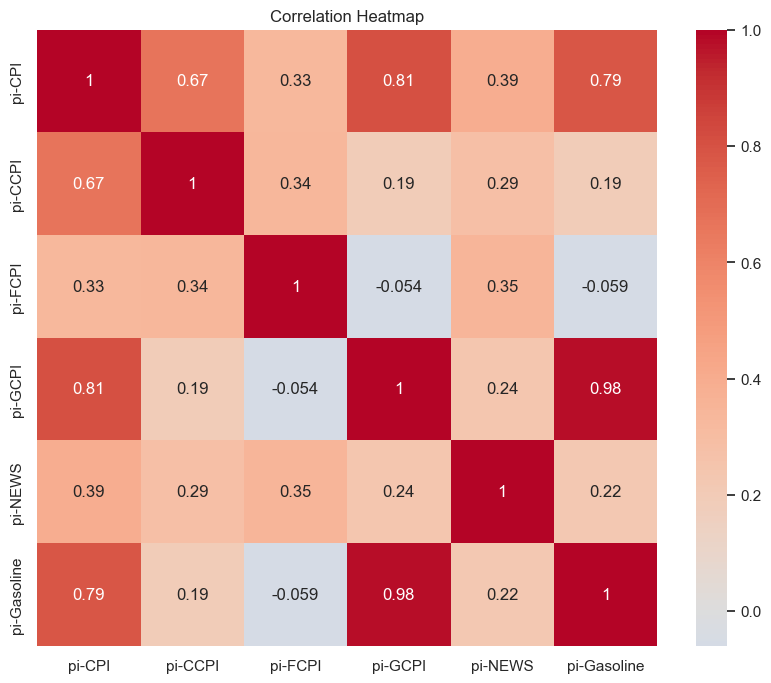

In [118]:
# Calculate the correlation matrix
corr_matrix = pi_df.corr()

# Print the correlation matrix (optional)
print(corr_matrix)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()
